In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime

In [13]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
df = pd.read_csv('/content/ACEN Historical Data_Cleaned.csv', usecols=['Date', 'Price'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df = df.sort_index()
df = df.asfreq('B')

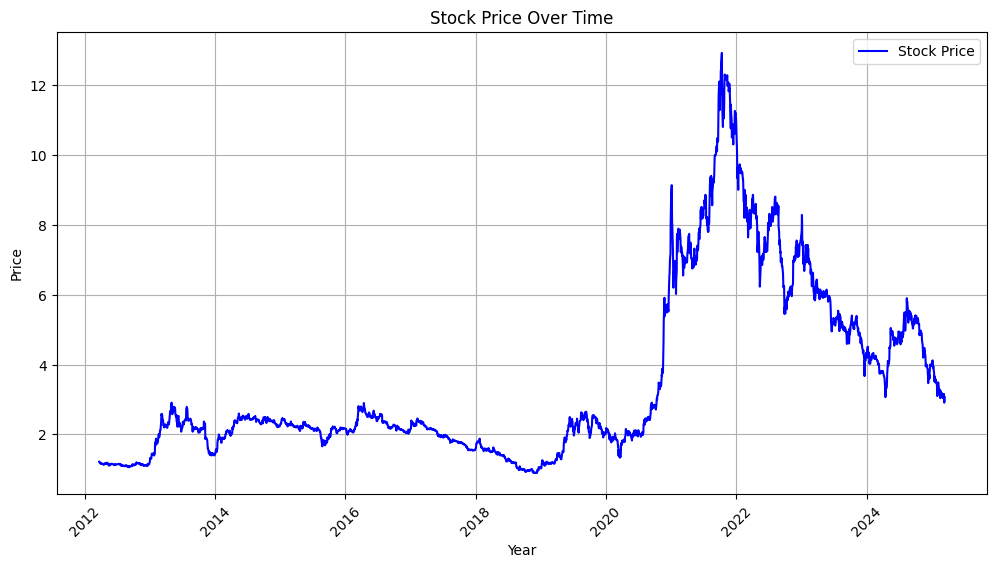

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label="Stock Price", color='blue')
plt.xlabel("Year")
plt.ylabel("Price")
plt.title("Stock Price Over Time")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.grid()
plt.show()

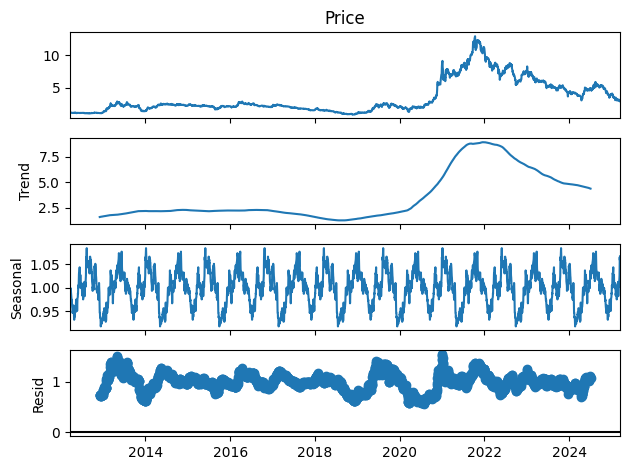

In [15]:
results = seasonal_decompose(df['Price'], model='multiplicative', period=365)
results.plot()
plt.show()

In [16]:
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
train = df.iloc[:train_size]
val = df.iloc[train_size:train_size+val_size]
test = df.iloc[train_size+val_size:]

In [17]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_val = scaler.transform(val)
scaled_test = scaler.transform(test)

In [18]:
scaled_train = np.array(scaled_train).reshape(-1, 1)
scaled_val = np.array(scaled_val).reshape(-1, 1)
scaled_test = np.array(scaled_test).reshape(-1, 1)

In [19]:
n_input = 90
n_features = 1
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
val_generator = TimeseriesGenerator(scaled_val, scaled_val, length=n_input, batch_size=1)

In [20]:
model = Sequential([
    LSTM(100, activation='tanh', return_sequences=True, input_shape=(n_input, n_features)),
    Dropout(0.2),
    LSTM(50, activation='tanh'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 90, 100)             │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 90, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,301 (282.43 KB)

 Trainable params: 72,301 (282.43 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
checkpoint = ModelCheckpoint("ACEN_model.h5", save_best_only=True, monitor='val_loss', mode='min')

In [31]:
history = model.fit(train_generator, epochs=30, validation_data=val_generator, callbacks=[early_stopping, checkpoint])

Epoch 1/30
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 251s 96ms/step - loss: 0.0011 - val_loss: 3.4237e-04
Epoch 2/30
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 256s 98ms/step - loss: 8.1839e-04 - val_loss: 5.0574e-04
Epoch 3/30
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 249s 95ms/step - loss: 7.4555e-04 - val_loss: 0.0017
Epoch 4/30
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 6.3769e-04

2619/2619 ━━━━━━━━━━━━━━━━━━━━ 252s 96ms/step - loss: 6.3770e-04 - val_loss: 1.6665e-04
Epoch 5/30
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 254s 97ms/step - loss: 8.3290e-04 - val_loss: 4.1956e-04
Epoch 6/30
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 257s 98ms/step - loss: 6.7707e-04 - val_loss: 1.9589e-04
Epoch 7/30
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 257s 98ms/step - loss: 6.1548e-04 - val_loss: 6.7930e-04
Epoch 8/30
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 260s 97ms/step - loss: 5.7953e-04 - val_loss: 8.8118e-04
Epoch 9/30
2619/2619 ━━━━━━━━━━━━━━━━━━━━ 256s 98ms/step - loss: 4.2379e-04 - val_loss: 5.1067e-04


In [32]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
model.save("ACEN_Model.h5")

In [33]:
full_scaled = scaler.transform(df)
full_scaled = np.array(full_scaled).reshape(-1, 1)
first_eval_batch = full_scaled[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

future_steps = 7
future_predictions = []

for i in range(future_steps):
    current_pred = model.predict(current_batch)[0]
    future_predictions.append(current_pred)
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


In [37]:
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

In [34]:
actual_recent = df.tail(23)

In [35]:
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=future_steps, freq='B')

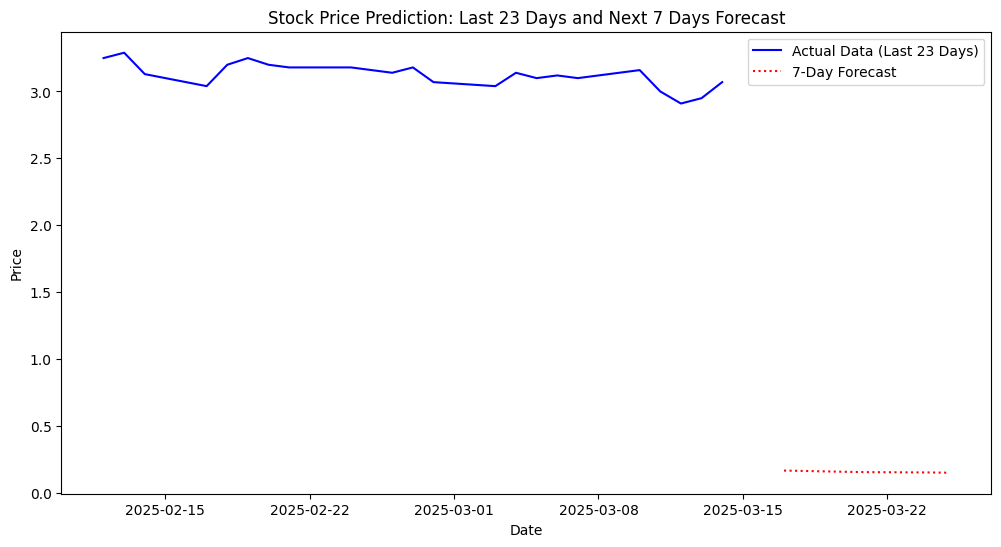

In [36]:
plt.figure(figsize=(12, 6))
plt.plot(actual_recent.index, actual_recent['Price'], label='Actual Data (Last 23 Days)', color='blue')
plt.plot(future_dates, future_predictions, linestyle='dotted', color='red', label='7-Day Forecast')
plt.legend()
plt.title("Stock Price Prediction: Last 23 Days and Next 7 Days Forecast")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [29]:
forecast_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Price': future_predictions.flatten()
})

In [30]:
forecast_df.to_csv('ACEN_predictions.csv', index=False)

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
print("Future predictions saved to 'future_predictions.csv'.")

Future predictions saved to 'future_predictions.csv'.
